In [31]:
import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import math
from scipy.ndimage import gaussian_filter1d


subject_id = "001"
experiment_id = "001"
monitor_width_cm = 47.6
monitor_height_cm = 26.8
resolution = (1920, 1080)
viewer_distance_cm = 70.0
cm_per_pixel_x = monitor_width_cm / resolution[0]
cm_per_pixel_y = monitor_height_cm / resolution[1]
viewing_distance_cm = 70
diag_length_cm = math.sqrt(monitor_width_cm**2 + monitor_height_cm**2)



In [32]:
pose1_df = pd.read_csv(f"./exported_csv/pose_df/pose1_df_id{subject_id}-{experiment_id}.csv")

In [33]:
def prepare_pose_df(df):
    df = df.copy()
    df["gx_centered"] = df["mean_x"] - 0.5
    df["gy_centered"] = df["mean_y"] - 0.5
    df["x_cm"] = df["gx_centered"] * resolution[0] * cm_per_pixel_x
    df["y_cm"] = df["gy_centered"] * resolution[1] * cm_per_pixel_y
    df["x_deg"] = np.degrees(np.arctan2(df["x_cm"], viewer_distance_cm))
    df["y_deg"] = np.degrees(np.arctan2(df["y_cm"], viewer_distance_cm))
    df["epoch_sec"] = df["epoch_time"]
    df["valid"] = df["validity_sum"] == 2
    return df


In [34]:
def interpolate_norm(df, time_col="epoch_sec", max_gap_ms=100):
    df = df.copy()
    df["valid"] = df["validity_sum"] == 2
    df["interp_x"] = np.nan
    df["interp_y"] = np.nan
    df.loc[df["valid"], "interp_x"] = df.loc[df["valid"], "mean_x"]
    df.loc[df["valid"], "interp_y"] = df.loc[df["valid"], "mean_y"]
    df["interp_x"] = df["interp_x"].interpolate(limit_area="inside")
    df["interp_y"] = df["interp_y"].interpolate(limit_area="inside")

    invalid_mask = ~df["valid"]
    group_id = (invalid_mask != invalid_mask.shift()).cumsum()
    invalid_blocks = df[invalid_mask].groupby(group_id)
    for _, block in invalid_blocks:
        if len(block) == 0:
            continue
        t_start = block[time_col].iloc[0]
        t_end = block[time_col].iloc[-1]
        duration_ms = (t_end - t_start)*1000
        if duration_ms > max_gap_ms:
            df.loc[block.index, ["interp_x", "interp_y"]] = np.nan
    return df


In [35]:
def filter_norm(df, sigma=1.0):
    df = df.copy()
    df["filtered_x"] = np.nan
    df["filtered_y"] = np.nan
    valid_mask = df["interp_x"].notna() & df["interp_y"].notna()
    block_id = (valid_mask != valid_mask.shift()).cumsum()
    blocks = df[valid_mask].groupby(block_id)

    for _, block in blocks:
        idx = block.index
        smoothed_x = gaussian_filter1d(block["interp_x"], sigma=sigma)
        smoothed_y = gaussian_filter1d(block["interp_y"], sigma=sigma)
        df.loc[idx, "filtered_x"] = smoothed_x
        df.loc[idx, "filtered_y"] = smoothed_y
    return df




In [36]:
def detect_fixations_ivt(df, resolution=(1920,1080), viewer_distance_cm=70.0, monitor_width_cm=47.6):
    fixations = []
    timestamps = df["epoch_sec"].to_numpy()
    xs = df["filtered_x"].to_numpy()
    ys = df["filtered_y"].to_numpy()

    # 視野角換算用
    cm_per_pixel_x = monitor_width_cm / resolution[0]

    delta_t = np.diff(timestamps)
    delta_x = np.diff(xs)
    delta_y = np.diff(ys)
    safe_delta_t = np.where(delta_t==0, np.nan, delta_t)
    velocities = np.sqrt(delta_x**2 + delta_y**2) / safe_delta_t
    velocities = np.insert(velocities, 0, 0)
    velocities = np.nan_to_num(velocities)

    in_fixation = False
    start_idx = 0

    for i in range(len(df)):
        if np.isnan(xs[i]) or np.isnan(ys[i]):
            if in_fixation:
                in_fixation = False
                t_start = timestamps[start_idx]
                t_end = timestamps[i-1]
                duration = (t_end - t_start)*1000
                if duration >= 100:
                    x_mean_norm = np.mean(xs[start_idx:i])
                    y_mean_norm = np.mean(ys[start_idx:i])
                    x_mean_px = x_mean_norm * resolution[0]
                    y_mean_px = y_mean_norm * resolution[1]
                    x_cm = (x_mean_norm - 0.5)*resolution[0]*cm_per_pixel_x
                    y_cm = (y_mean_norm - 0.5)*resolution[1]*cm_per_pixel_x
                    x_deg = np.degrees(np.arctan2(x_cm, viewer_distance_cm))
                    y_deg = np.degrees(np.arctan2(y_cm, viewer_distance_cm))
                    fixations.append({
                        "start_time": t_start,
                        "end_time": t_end,
                        "duration_ms": duration,
                        "x_mean_norm": x_mean_norm,
                        "y_mean_norm": y_mean_norm,
                        "x_mean_px": x_mean_px,
                        "y_mean_px": y_mean_px,
                        "x_mean_deg": x_deg,
                        "y_mean_deg": y_deg,
                    })
            continue
        if velocities[i] < 100:
            if not in_fixation:
                in_fixation = True
                start_idx = i
        else:
            if in_fixation:
                in_fixation = False
                t_start = timestamps[start_idx]
                t_end = timestamps[i-1]
                duration = (t_end - t_start)*1000
                if duration >= 100:
                    x_mean_norm = np.mean(xs[start_idx:i])
                    y_mean_norm = np.mean(ys[start_idx:i])
                    x_mean_px = x_mean_norm * resolution[0]
                    y_mean_px = y_mean_norm * resolution[1]
                    x_cm = (x_mean_norm - 0.5)*resolution[0]*cm_per_pixel_x
                    y_cm = (y_mean_norm - 0.5)*resolution[1]*cm_per_pixel_x
                    x_deg = np.degrees(np.arctan2(x_cm, viewer_distance_cm))
                    y_deg = np.degrees(np.arctan2(y_cm, viewer_distance_cm))
                    fixations.append({
                        "start_time": t_start,
                        "end_time": t_end,
                        "duration_ms": duration,
                        "x_mean_norm": x_mean_norm,
                        "y_mean_norm": y_mean_norm,
                        "x_mean_px": x_mean_px,
                        "y_mean_px": y_mean_px,
                        "x_mean_deg": x_deg,
                        "y_mean_deg": y_deg,
                    })

    # 最後のfixation
    if in_fixation:
        t_start = timestamps[start_idx]
        t_end = timestamps[-1]
        duration = (t_end - t_start)*1000
        if duration >= 100:
            x_mean_norm = np.mean(xs[start_idx:])
            y_mean_norm = np.mean(ys[start_idx:])
            x_mean_px = x_mean_norm * resolution[0]
            y_mean_px = y_mean_norm * resolution[1]
            x_cm = (x_mean_norm - 0.5)*resolution[0]*cm_per_pixel_x
            y_cm = (y_mean_norm - 0.5)*resolution[1]*cm_per_pixel_x
            x_deg = np.degrees(np.arctan2(x_cm, viewer_distance_cm))
            y_deg = np.degrees(np.arctan2(y_cm, viewer_distance_cm))
            fixations.append({
                "start_time": t_start,
                "end_time": t_end,
                "duration_ms": duration,
                "x_mean_norm": x_mean_norm,
                "y_mean_norm": y_mean_norm,
                "x_mean_px": x_mean_px,
                "y_mean_px": y_mean_px,
                "x_mean_deg": x_deg,
                "y_mean_deg": y_deg,
            })

    return pd.DataFrame(fixations)


In [37]:
def process_pose_df_ivt(df):
    df_prepared = prepare_pose_df(df)
    df_interp = interpolate_norm(df_prepared)
    df_filtered = filter_norm(df_interp)
    fix_df = detect_fixations_ivt(df_filtered)
    return fix_df


In [38]:
fix_df = process_pose_df_ivt(pose1_df)
# print(fix_df)
# fix_df.to_csv(f"./exported_csv/pose_df/pose_fix_df/pose_fix_df_id{subject_id}-{experiment_id}.csv", index=False)

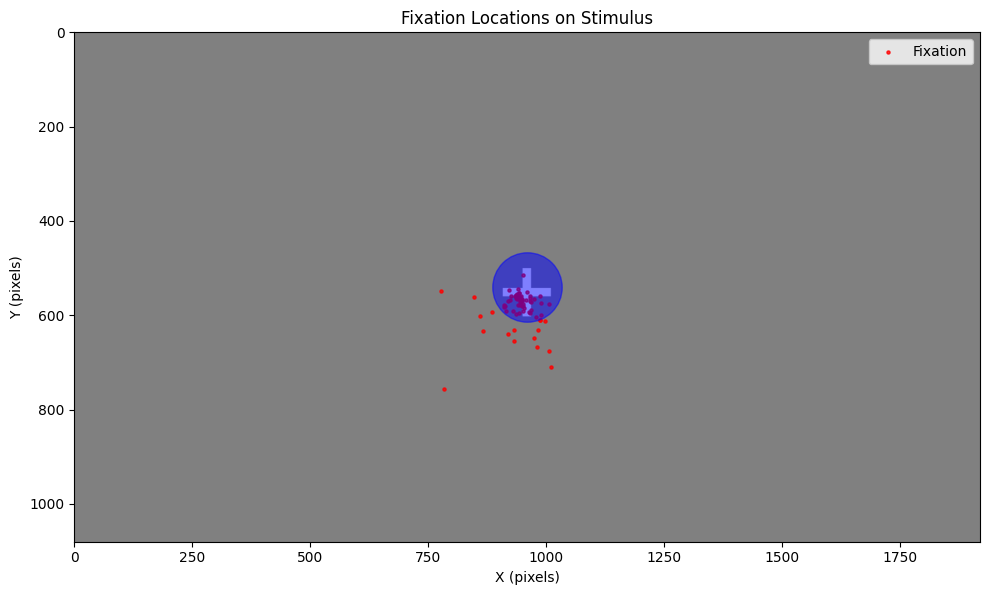

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# === 背景画像の読み込み ===

img = mpimg.imread("../koshiten.png")

# === 画面サイズ（ピクセル） ===
width_px, height_px = resolution

# === 注視点の座標を計算 ===
x_px = fix_df["x_mean_norm"] * width_px
y_px = fix_df["y_mean_norm"] * height_px

# === プロット ===
fig, ax = plt.subplots(figsize=(10, 6))

# 中心の座標
center_x = 1920 / 2
center_y = 1080 / 2
# 中心に点をプロット
ax.plot(center_x, center_y, 'bo', markersize=50,alpha=0.5)  # 'ro'は赤い点
# 背景画像
ax.imshow(img, extent=[0, width_px, height_px, 0])

# 注視点
ax.scatter(
    x_px,
    y_px,
    c="red",
    s=5,
    alpha=0.8,
    label="Fixation"
)

# 軸設定
ax.set_xlim(0, width_px)
ax.set_ylim(height_px, 0)
ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
ax.set_title("Fixation Locations on Stimulus")
ax.legend()

plt.tight_layout()
plt.show()


In [44]:
pose_fix_df =  pd.read_csv(f"./exported_csv/pose_df/pose_fix_df/pose_fix_df_id{subject_id}-{experiment_id}.csv")

In [46]:
import pandas as pd
import numpy as np

# 中心座標（画面中央）
center_x = 1920 / 2
center_y = 1080 / 2

# 中心からの距離を計算
pose_fix_df["distance_px"] = np.sqrt(
    (pose_fix_df["x_mean_px"] - center_x) ** 2 + (pose_fix_df["y_mean_px"] - center_y) ** 2
)

# 半径100px以内に収まる注視点を判定
within_radius = pose_fix_df["distance_px"] <= 100

# 件数・割合を計算
count_within = within_radius.sum()
ratio_within = count_within / len(pose_fix_df)

# 結果を表示
print(f"半径100px以内の注視点数: {count_within}")
print(f"全体に対する割合: {ratio_within:.2%}")

# 必要なら該当行を表示
print(pose_fix_df.loc[within_radius, ["x_mean_px", "y_mean_px", "distance_px"]])


半径100px以内の注視点数: 56
全体に対する割合: 83.58%
      x_mean_px   y_mean_px  distance_px
0    968.015749  589.201535    49.850209
3    951.879275  514.670332    26.599591
4    950.921071  591.870540    52.659091
5    986.908586  558.975162    32.926111
6    942.481172  551.830907    21.139529
7    922.412537  545.930957    38.052511
8    941.834814  552.724122    22.178306
9    944.340435  572.565518    36.134954
10   936.884232  556.752584    28.547991
11   952.820900  583.696480    44.282298
12   974.091539  565.461861    29.101166
13  1006.223840  576.387181    58.827462
14   978.205231  604.185868    66.717734
15   983.625944  630.923279    93.942684
16   919.764032  569.506877    49.895780
17   964.908611  569.719886    30.122518
19   988.338457  600.345221    66.667937
22   951.443375  575.226697    36.251014
23   950.671384  579.361321    40.451658
24   938.684926  566.025112    33.639840
25   926.273100  558.645236    38.537626
26   948.074982  570.064283    32.342962
27   909.960369  579.

In [ ]:
# def evaluate_accuracy(df, pose_name):
#     total_len = len(df)
    
#     # validity_sum == 2 のデータのみを使う
#     valid_df = df[df["validity_sum"] == 2].copy()

#     valid_df["mean_x"] = (valid_df["left_x"] + valid_df["right_x"]) / 2
#     valid_df["mean_y"] = (valid_df["left_y"] + valid_df["right_y"]) / 2
#     valid_df = valid_df.dropna(subset=["mean_x", "mean_y"])
#     if valid_df.empty:
#         raise ValueError("有効なデータがありません。")

#     # データ行列
#     data = valid_df[["mean_x", "mean_y"]].values

#     # 重心
#     center = np.mean(data, axis=0)

#     # 共分散行列と逆行列
#     cov = np.cov(data, rowvar=False)
#     inv_cov = np.linalg.inv(cov)

#     # 差分
#     diff = data - center
#     left = np.dot(diff, inv_cov)
#     mahal_sq = np.sum(left * diff, axis=1)
#     mahal_dist = np.sqrt(mahal_sq)

#     # σ=1以内
#     within_sigma1 = np.sum(mahal_dist <= 1)
#     total_valid = len(mahal_dist)
#     percent_sigma1 = 100 * within_sigma1 / total_valid

#     # 平均マハラノビス距離
#     mahal_mean = np.mean(mahal_dist)

#     # ユークリッド距離も参考値で計算（正確度）
#     euclid_dist = np.linalg.norm(diff, axis=1)
#     euclid_mean = np.mean(euclid_dist)

#     # ユークリッド距離→cm→視野角
#     euclid_mean_cm = euclid_mean * diag_length_cm
#     euclid_mean_deg = np.degrees(np.arctan(euclid_mean_cm / viewing_distance_cm))

#     # 結果
#     return {
#         "subject_id": subject_id,
#         "task_id": experiment_id,
#         "pose": pose_name,
#         "pose_length": total_len,
#         "valid_data_count": total_valid,
#         "center_x": center[0],
#         "center_y": center[1],
#         "mahalanobis_mean": mahal_mean,
#         "percent_within_sigma1": percent_sigma1,
#         "euclid_mean": euclid_mean,
#         "euclid_mean_deg": euclid_mean_deg,
#     }

In [ ]:
summary_list = []
summary_list.append(evaluate_precision(fix_df))

In [ ]:
summary_df = pd.DataFrame(summary_list)
summary_df

,subject_id,task_id,pose_length,center_x,center_y,mahalanobis_mean,percent_within_sigma1,euclid_mean,euclid_mean_deg
0,001,001,67,0.4909,0.543533,1.064662,64.179104,0.032492,1.452478
